# Step 1: Per-Dataset Analysis

In [1]:
# pip install numpy pandas scipy statsmodels scikit-posthocs matplotlib seaborn

In [2]:
# binary, multiclass, multilabel_native, multilabel_powerset, all
scenario = "binary"
# significance level (used globally)
alpha = 0.05 

In [3]:
# Parameters
scenario = "multiclass"
alpha = 0.05


In [4]:
# change ~/anaconda3/Lib/site-packages/matplotlib/_mathtext.py:659
# to uniindex = 0x2D  # currency char, for lack of anything better
from matplotlib import font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths=['fonts'])
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    prop = font_manager.FontProperties(fname=font_file)
    print(font_file, prop.get_name())

plt.rcParams['font.family'] = ['CMU Serif', 'DejaVu Sans']
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.unicode_minus'] = False

C:\Users\marce\git\auto-ml-evaluation-2025\fonts\cmunrm.ttf CMU Serif
C:\Users\marce\git\auto-ml-evaluation-2025\fonts\cmunbx.ttf CMU Serif
C:\Users\marce\git\auto-ml-evaluation-2025\fonts\cmunti.ttf CMU Serif


In [5]:
from IPython.display import display
from scipy.stats import shapiro, levene, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np
import os
import pandas as pd
import scikit_posthocs as sp
import seaborn as sns

In [6]:
def arcsine_sqrt_transform(x, eps=1e-6):
    """
    Applies arcsine sqrt transform for data in [0,1].
    Handles corner cases by clamping [0,1] to [eps, 1-eps].
    """
    x_clamped = np.clip(x, eps, 1.0 - eps)
    return np.arcsin(np.sqrt(x_clamped))

In [7]:
def log1p_transform(x, eps=1e-6):
    """
    Safely applies log(1 + x). 
    If any x < 0, add a small shift so that all data >= -0.9999... 
    (In typical training-time data, negative times shouldn't occur. 
     But in case of small floating errors, handle it.)
    """
    min_val = x.min()
    shift = 0.0
    if min_val < 0:
        shift = abs(min_val) + eps  # ensure positivity
    return np.log1p(x + shift)

In [8]:
def check_normality_auto(data, threshold=50):
    """
    Automatically choose between Shapiro–Wilk (SW) and Kolmogorov–Smirnov (K–S)
    based on sample size.
    
    :param data: 1D array-like of numeric values
    :param threshold: sample-size threshold for deciding which test to use
    :return: dict with keys: 
        'test_name', 'statistic', 'p_value', 'is_normal'
    """
    data = pd.Series(data).dropna()  # ensure it's a clean Series
    n = len(data)
    
    # If not enough points or no data
    if n < 3:
        return {
            'test_name': 'none',
            'statistic': np.nan,
            'p_value': np.nan,
            'is_normal': False,
            'reason': f"Not enough data points (n={n})"
        }
    
    if n <= threshold:
        # Use Shapiro–Wilk
        stat, p_val = shapiro(data)
        test_name = 'Shapiro-Wilk'
    else:
        # Use Kolmogorov–Smirnov
        # We compute the mean and std of the data to define the normal distribution
        mu, sigma = data.mean(), data.std(ddof=1)
        if sigma == 0:
            # If all data are identical, that might cause zero std
            # K-S is not well-defined here, or it trivially fails
            return {
                'test_name': 'Kolmogorov-Smirnov',
                'statistic': 0.0,
                'p_value': 1.0,
                'is_normal': True,
                'reason': 'All data points identical'
            }
        # kstest with cdf='norm' requires specifying loc=mu, scale=sigma
        stat, p_val = kstest(data, 'norm', args=(mu, sigma))
        test_name = 'Kolmogorov-Smirnov'
    
    is_normal = (p_val > alpha)
    return {
        'test_name': test_name,
        'statistic': stat,
        'p_value': p_val,
        'is_normal': is_normal
    }

In [9]:
def check_normality_variances(df, metric_col='f1', group_col='framework'):
    """
    1) Checks normality for each framework (automatically deciding between
       Shapiro-Wilk or Kolmogorov-Smirnov) and collects results in norm_results.
    2) Determines 'normal' = True if *all* frameworks pass the normality test at alpha.
    3) Checks homogeneity of variances via Levene’s test across all frameworks.
    
    Returns:
      norm_results: dict mapping framework -> { 'test_name', 'statistic', 'p_value', 'is_normal', ... }
      normal: bool indicating if all frameworks are normal
      homoscedastic: bool indicating if Levene’s test fails to reject equal variances
    """
    frameworks = df[group_col].unique()
    
    # Dictionary to store normality results per framework
    norm_results = {}
    
    # 1) Check normality for each group (framework)
    pvals_normality = []
    for fw in frameworks:
        data_fw = df.loc[df[group_col] == fw, metric_col].dropna()
        # Decide between Shapiro-Wilk or Kolmogorov-Smirnov tests automatically
        norm_res = check_normality_auto(data_fw, threshold=50)
        norm_results[fw] = norm_res
        # Check if the normality test was actually performed
        if norm_res['test_name'] != 'none':
            # We'll store the p-value to see if each group individually passes normality
            pvals_normality.append(norm_res['p_value'])
    
    # "Normal" if all frameworks pass the normality test (is_normal == True)
    # We only consider frameworks that had enough data for a test.
    # If pvals_normality is empty (no frameworks or all had <3 data), normal=False
    if len(pvals_normality) == 0:
        normal = False
    else:
        normal = all(p > alpha for p in pvals_normality)
    
    # 2) Check homogeneity of variances using Levene’s test
    group_data = [df.loc[df[group_col] == fw, metric_col].dropna() for fw in frameworks]
    if sum(len(g) > 0 for g in group_data) < 2:
        homoscedastic = False
    else:
        stat, pval = levene(*[g for g in group_data if len(g) > 1])
        homoscedastic = (pval > alpha)
    
    return norm_results, normal, homoscedastic

In [10]:
def do_parametric_anova(df, metric_col='f1', group_col='framework'):
    """
    Performs one-way ANOVA + Tukey post-hoc if significant.
    Ensures all frameworks appear in the pairwise matrix, even if they have no valid trials.
    """
    results = {}
    frameworks = sorted(df[group_col].unique())  # Ensure consistent ordering
    data_groups = [df.loc[df[group_col] == fw, metric_col].dropna() for fw in frameworks]

    # Check for empty groups or all identical values
    if any(len(g) < 2 for g in data_groups) or all(np.var(g) == 0 for g in data_groups if len(g) > 1):
        results['anova_F'] = np.nan
        results['anova_p'] = np.nan
        tukey_matrix = pd.DataFrame(np.nan, index=frameworks, columns=frameworks)
        results['posthoc'] = tukey_matrix
        return results

    # ANOVA Test
    f_stat, p_val = f_oneway(*data_groups)
    results['anova_F'] = f_stat
    results['anova_p'] = p_val

    # Prepare an empty symmetrical matrix with NaNs
    tukey_matrix = pd.DataFrame(np.nan, index=frameworks, columns=frameworks)

    if p_val < alpha:
        # Tukey Post-Hoc Test
        metric_values = []
        group_labels = []
        for fw, g_data in zip(frameworks, data_groups):
            metric_values.extend(g_data)
            group_labels.extend([fw] * len(g_data))

        tukey = pairwise_tukeyhsd(endog=metric_values, groups=group_labels, alpha=alpha)

        # Fill Tukey results into the matrix
        for i, j, p_val in zip(tukey._multicomp.pairindices[0], tukey._multicomp.pairindices[1], tukey.pvalues):
            fw1, fw2 = tukey.groupsunique[i], tukey.groupsunique[j]
            tukey_matrix.loc[fw1, fw2] = p_val
            tukey_matrix.loc[fw2, fw1] = p_val  # Mirror the matrix

    results['posthoc'] = tukey_matrix  # Store the complete matrix

    return results

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
import scikit_posthocs as sp

def do_nonparametric_kruskal(df, all_frameworks, metric_col='f1', group_col='framework'):
    """
    Performs Kruskal-Wallis + Dunn post-hoc if significant.
    Ensures all frameworks appear in the pairwise matrix, even if they have no valid trials.
    
    Parameters:
        - df: DataFrame with results
        - metric_col: Metric being analyzed
        - group_col: Framework column name
        - alpha: Significance level
        - all_frameworks: List of all possible frameworks (even if missing in df)
    
    Returns:
        - Dictionary with Kruskal-Wallis test results and posthoc Dunn matrix.
    """
    results = {}

    # Ensure ALL frameworks are considered (even those missing from df)
    if all_frameworks is None:
        all_frameworks = sorted(df[group_col].unique())  # Default: existing frameworks only
    else:
        all_frameworks = sorted(all_frameworks)  # Use full list of expected frameworks

    # Extract valid data groups (ignore completely missing frameworks for now)
    valid_groups = {fw: df.loc[df[group_col] == fw, metric_col].dropna().values for fw in all_frameworks}
    
    # Filter out empty lists (frameworks that never produced results)
    valid_groups = {fw: data for fw, data in valid_groups.items() if len(data) > 0}
    
    # Check if we have at least two valid frameworks for Kruskal-Wallis
    if len(valid_groups) < 2:
        results['kruskal_H'] = np.nan
        results['kruskal_p'] = np.nan
        dunn_matrix = pd.DataFrame(np.nan, index=all_frameworks, columns=all_frameworks)
        results['posthoc'] = dunn_matrix
        return results

    # Run Kruskal-Wallis on valid groups only
    try:
        h_stat, p_val = kruskal(*valid_groups.values(), nan_policy='omit')
    except ValueError:  # Handles cases where Kruskal cannot be computed
        h_stat, p_val = np.nan, np.nan

    results['kruskal_H'] = h_stat
    results['kruskal_p'] = p_val

    # Prepare an empty symmetrical matrix with NaNs (ensures all frameworks appear)
    dunn_matrix = pd.DataFrame(np.nan, index=all_frameworks, columns=all_frameworks)

    if p_val < alpha:
        # Dunn Post-Hoc Test (only if we had valid groups)
        df_ph = df[[group_col, metric_col]].dropna()
        if not df_ph.empty:
            dunn_res = sp.posthoc_dunn(df_ph, val_col=metric_col, group_col=group_col, p_adjust='holm')

            # Ensure ALL frameworks are in the matrix (even if missing from Dunn’s results)
            for fw1 in all_frameworks:
                for fw2 in all_frameworks:
                    if fw1 in dunn_res.index and fw2 in dunn_res.columns:
                        dunn_matrix.loc[fw1, fw2] = dunn_res.loc[fw1, fw2]

    results['posthoc'] = dunn_matrix  # Store the complete matrix

    return results


In [12]:
def decide_transform_and_analyze(df, all_frameworks, metric_col, group_col='framework'):
    """
    1) Decide transform:
       - If metric_col == 'f1', do arcsine sqrt transform
       - If metric_col == 'training_time', do log1p transform
       - Otherwise, no transform.
    2) Check normality & homoscedasticity on transformed data
    3) If normal & homoscedastic:
         -> ANOVA + Tukey on transformed data
       Else:
         -> Kruskal-Wallis + Dunn on original data
    """
    result = {}
    
    # Drop rows with missing values for this metric
    df = df.dropna(subset=[metric_col]).copy()
    
    # If fewer than 2 frameworks have valid data, skip
    unique_fw = df[group_col].unique()
    if len(unique_fw) < 2:
        result['warning'] = 'Fewer than 2 frameworks have data; skipping test.'
        return result
    
    # Decide which transform to apply
    if metric_col == 'f1':
        # arcsine sqrt transform (common for [0,1] data)
        df['transformed_val'] = arcsine_sqrt_transform(df[metric_col].values)
        chosen_transform = 'arcsine_sqrt'
    elif metric_col == 'training_time':
        # log1p transform (common for skewed positive data)
        df['transformed_val'] = log1p_transform(df[metric_col].values)
        chosen_transform = 'log1p'
    else:
        # default: no transform
        df['transformed_val'] = df[metric_col]
        chosen_transform = 'none'
    
    result['chosen_transform'] = chosen_transform
    
    # ----------------------------------------------------
    # 1) Check parametric assumptions on the transformed data
    #    We'll create a mini DataFrame with just {group_col, 'transformed_val'}
    #    and pass 'transformed_val' as 'metric_col' to the checking function
    # ----------------------------------------------------
    df_for_assumptions = df[[group_col, 'transformed_val']].copy()
    
    norm_results, normal, homoscedastic = check_normality_variances(
        df_for_assumptions,
        metric_col='transformed_val',
        group_col=group_col
    )

    result['normal_tests'] = set([v['test_name'] for v in norm_results.values()])
    result['assumptions'] = {'normal': normal, 'homoscedastic': homoscedastic}
    
    # ----------------------------------------------------
    # 2) Decide which statistical test to run
    # ----------------------------------------------------
    if normal and homoscedastic:
        # Use parametric: One-Way ANOVA + Tukey
        result['method'] = 'ANOVA + Tukey'
        
        # We'll do ANOVA on the transformed values
        # Make a small DataFrame with the same format as do_parametric_anova expects:
        # it looks for a column matching 'metric_col' for the data.
        anova_df = df_for_assumptions.rename(columns={'transformed_val': 'temp_metric'})
        
        # Now run ANOVA with metric_col='temp_metric'
        out = do_parametric_anova(
            anova_df,
            metric_col='temp_metric',
            group_col=group_col
        )
        result.update(out)
        
    else:
        # Use non-parametric: Kruskal-Wallis + Dunn
        # Typically, we run it on the ORIGINAL metric (not transformed)
        result['method'] = 'Kruskal-Wallis + Dunn'
        
        # Build a mini DataFrame with just {group_col, <original metric>}
        kruskal_df = df[[group_col, metric_col]].copy()

        out = do_nonparametric_kruskal(
            kruskal_df,
            all_frameworks=all_frameworks,
            metric_col=metric_col,
            group_col=group_col
        )
        result.update(out)
    
    return result

In [13]:
def analyze_per_dataset(df):
    """
    Loops through each dataset, does a separate analysis for 'f1' and 'training_time'.
    Applies appropriate transform automatically for parametric test attempts.
    Returns a list of results, one per dataset.
    """
    all_results = []
    datasets = df['dataset'].unique()
    all_frameworks = df['framework'].unique().tolist()
    
    for dset in datasets:
        dsub = df[df['dataset'] == dset]
        
        # Analyze F1
        f1_res = decide_transform_and_analyze(dsub, all_frameworks, metric_col='f1')
        
        # Analyze training_time
        time_res = decide_transform_and_analyze(dsub, all_frameworks, metric_col='training_time')
        
        row = {
            'dataset': dset,
            'f1_analysis': f1_res,
            'time_analysis': time_res
        }
        all_results.append(row)
    
    return all_results

In [14]:
def print_formatted_result(k, v):
    if k == 'posthoc':
        print('  posthoc:')
        display(v)
    else:
        print(f"  {k}: {v}")

In [15]:
# ========================
# ====== MAIN CALL =======
# ========================

# Example CSV structure: dataset, framework, trial, f1, training_time
# e.g., "31,autogluon,1,0.6949,8.6927"
df = pd.read_csv(f"stats/{scenario}/experimental_results.csv")
df = df.rename(columns={
    'Dataset': 'dataset', 
    'Dataset Type': 'type', 
    'Framework': 'framework', 
    'Trial': 'trial', 
    'F1 Score': 'f1', 
    'Training Time': 'training_time'}
)

# Run the analysis
results = analyze_per_dataset(df)

# Assert statistical significance
# assert len(results) == df['dataset'].nunique(), 'Some datasets are missing in the results'
# assert all(isinstance(r['f1_analysis']['posthoc'], pd.DataFrame) for r in results), "Not all posthoc F1 Score results are DataFrames"
# assert all(isinstance(r['time_analysis']['posthoc'], pd.DataFrame) for r in results), "Not all posthoc Training Time results are DataFrames"

# Print some sample outputs
for r in results:
    print(f"\n===== Dataset {r['dataset']} =====")
    print("F1 Analysis:")
    for k, v in r['f1_analysis'].items():
        print_formatted_result(k, v)
    print("\nTime Analysis:")
    for k, v in r['time_analysis'].items():
        print_formatted_result(k, v)

C:\Users\marce\anaconda3\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)



===== Dataset 23 =====
F1 Analysis:
  chosen_transform: arcsine_sqrt
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 156.22395519340708
  kruskal_p: 1.3935700549809054e-25
  posthoc:


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,fedot,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000,1.000000,0.002292,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.703410e-05,4.619547e-05,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
autogluon,1.000000,1.000000,0.001665,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.151763e-05,3.182012e-05,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
autokeras,0.002292,0.001665,1.000000,0.748102,1.380576e-06,1.374821e-05,3.182012e-05,0.002107,1.322232e-06,1.000000e+00,1.000000e+00,0.001701,1.151529e-05,0.091991,4.560986e-05,4.619547e-05
autopytorch,1.000000,1.000000,0.748102,1.000000,1.600154e-01,5.813140e-01,9.080480e-01,1.000000,1.571481e-01,2.583294e-02,5.411553e-02,1.000000,5.255060e-01,1.000000,1.000000e+00,1.000000e+00
autosklearn,1.000000,1.000000,0.000001,0.160015,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,2.383158e-09,9.019908e-09,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
evalml,1.000000,1.000000,0.000014,0.581314,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,3.601528e-08,1.245409e-07,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
fedot,1.000000,1.000000,0.000032,0.908048,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000425e-07,3.290787e-07,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
flaml,1.000000,1.000000,0.002107,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.530744e-05,4.215721e-05,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
gama,1.000000,1.000000,0.000001,0.157148,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,2.259529e-09,8.568271e-09,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
h2o,0.000017,0.000012,1.000000,0.025833,2.383158e-09,3.601528e-08,1.000425e-07,0.000015,2.259529e-09,1.000000e+00,1.000000e+00,0.000012,2.845976e-08,0.010219,1.570551e-07,1.600470e-07



Time Analysis:
  chosen_transform: log1p
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 274.3861604831752
  kruskal_p: 1.146161439809178e-49
  posthoc:


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,fedot,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000,5.097703e-02,1.000000e+00,1.526289e-04,1.000000e+00,1.152659e-01,3.300065e-02,1.000000e+00,1.000000,2.881742e-02,1.000000,1.399118e-04,4.674248e-01,1.000000,3.637179e-03,6.818462e-03
autogluon,0.050977,1.000000e+00,1.000000e+00,4.705935e-14,1.195310e-04,1.008428e-08,7.183608e-10,1.390009e-04,0.042952,5.492147e-10,0.149812,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,3.601281e-11
autokeras,1.000000,1.000000e+00,1.000000e+00,2.129455e-09,4.490795e-02,4.273355e-05,5.227285e-06,4.977638e-02,1.000000,4.229430e-06,1.000000,2.415468e-01,1.000000e+00,1.000000,1.000000e+00,4.829686e-07
autopytorch,0.000153,4.705935e-14,2.129455e-09,1.000000e+00,6.036490e-02,1.000000e+00,1.000000e+00,5.461000e-02,0.000202,1.000000e+00,0.000029,1.224480e-19,1.398708e-11,0.391382,9.930767e-17,1.000000e+00
autosklearn,1.000000,1.195310e-04,4.490795e-02,6.036490e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,3.629006e-08,3.252701e-03,1.000000,2.699138e-06,7.611081e-01
evalml,0.115266,1.008428e-08,4.273355e-05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.138435,1.000000e+00,0.039763,2.928176e-13,8.998383e-07,1.000000,7.015155e-11,1.000000e+00
fedot,0.033001,7.183608e-10,5.227285e-06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.039763,1.000000e+00,0.009282,1.194642e-14,8.400047e-08,1.000000,3.783228e-12,1.000000e+00
flaml,1.000000,1.390009e-04,4.977638e-02,5.461000e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,4.422054e-08,3.647683e-03,1.000000,3.213114e-06,7.084825e-01
gama,1.000000,4.295179e-02,1.000000e+00,2.022941e-04,1.000000e+00,1.384354e-01,3.976325e-02,1.000000e+00,1.000000,3.504586e-02,1.000000,1.074442e-04,3.989946e-01,1.000000,2.883441e-03,8.486377e-03
h2o,0.028817,5.492147e-10,4.229430e-06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.035046,1.000000e+00,0.008105,8.628752e-15,6.609945e-08,1.000000,2.811425e-12,1.000000e+00



===== Dataset 36 =====
F1 Analysis:
  chosen_transform: arcsine_sqrt
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 82.91978278215635
  kruskal_p: 2.034901336305258e-11
  posthoc:


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,fedot,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000,1.000000,0.001824,0.000566,1.000000,0.007676,1.0,1.000000,1.00000,1.000000,0.105559,0.066831,0.663447,1.0,1.000000,0.013617
autogluon,1.000000,1.000000,0.085308,0.034203,1.000000,0.252105,1.0,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.375861
autokeras,0.001824,0.085308,1.000000,1.000000,0.000311,1.000000,1.0,0.003947,1.00000,0.016713,1.000000,1.000000,1.000000,1.0,0.022290,1.000000
autopytorch,0.000566,0.034203,1.000000,1.000000,0.000086,1.000000,1.0,0.001292,0.53654,0.006098,1.000000,1.000000,1.000000,1.0,0.008212,1.000000
autosklearn,1.000000,1.000000,0.000311,0.000086,1.000000,0.001495,1.0,1.000000,1.00000,1.000000,0.027379,0.016444,0.215373,1.0,1.000000,0.002859
evalml,0.007676,0.252105,1.000000,1.000000,0.001495,1.000000,1.0,0.015536,1.00000,0.058439,1.000000,1.000000,1.000000,1.0,0.075308,1.000000
fedot,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
flaml,1.000000,1.000000,0.003947,0.001292,1.000000,0.015536,1.0,1.000000,1.00000,1.000000,0.188665,0.118606,1.000000,1.0,1.000000,0.026146
gama,1.000000,1.000000,1.000000,0.536540,1.000000,1.000000,1.0,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
h2o,1.000000,1.000000,0.016713,0.006098,1.000000,0.058439,1.0,1.000000,1.00000,1.000000,0.551319,0.375861,1.000000,1.0,1.000000,0.091973



Time Analysis:
  chosen_transform: log1p
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 260.99647395898387
  kruskal_p: 6.708752487361563e-47
  posthoc:


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,fedot,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000e+00,8.616229e-05,3.069872e-05,6.636174e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.987031,1.000000e+00,5.855103e-02,1.762510e-11,3.878029e-08,1.000000,1.469528e-04,2.630174e-03
autogluon,8.616229e-05,1.000000e+00,1.000000e+00,1.637758e-11,5.198578e-06,1.433799e-04,4.658617e-05,7.132252e-04,0.557875,5.651970e-08,1.000000e+00,6.714533e-01,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
autokeras,3.069872e-05,1.000000e+00,1.000000e+00,3.369148e-12,1.585545e-06,5.168190e-05,1.756031e-05,2.701523e-04,0.332067,1.501524e-08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
autopytorch,6.636174e-01,1.637758e-11,3.369148e-12,1.000000e+00,1.000000e+00,5.177712e-01,1.000000e+00,2.027430e-01,0.000120,1.000000e+00,5.698617e-07,6.156855e-21,2.250971e-16,0.021798,3.741838e-11,4.148574e-09
autosklearn,1.000000e+00,5.198578e-06,1.585545e-06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.250967,1.000000e+00,7.898550e-03,2.666563e-13,1.056769e-09,1.000000,9.540620e-06,2.410115e-04
evalml,1.000000e+00,1.433799e-04,5.168190e-05,5.177712e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,8.385771e-02,3.775653e-11,7.385012e-08,1.000000,2.415383e-04,4.018108e-03
fedot,1.000000e+00,4.658617e-05,1.756031e-05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.401824,1.000000e+00,2.201817e-02,3.762171e-11,3.878029e-08,1.000000,7.732729e-05,1.116740e-03
flaml,1.000000e+00,7.132252e-04,2.701523e-04,2.027430e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,2.509670e-01,4.648931e-10,6.089076e-07,1.000000,1.168728e-03,1.578122e-02
gama,9.870310e-01,5.578754e-01,3.320674e-01,1.197722e-04,2.509670e-01,1.000000e+00,4.018236e-01,1.000000e+00,1.000000,1.936144e-02,1.000000e+00,4.049364e-05,6.150831e-03,1.000000,7.254559e-01,1.000000e+00
h2o,1.000000e+00,5.651970e-08,1.501524e-08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.019361,1.000000e+00,2.863848e-04,4.251832e-16,4.124614e-12,0.351749,1.129866e-07,5.241983e-06



===== Dataset 54 =====
F1 Analysis:
  chosen_transform: arcsine_sqrt
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 169.39880212942137
  kruskal_p: 3.2272653010026014e-28
  posthoc:


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,fedot,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000,1.000000,1.000000,0.108878,1.215034e-03,7.625074e-01,9.773239e-04,1.000000,1.000000,1.000000,1.000000e+00,7.785081e-01,1.000000,0.232036,9.846094e-05,1.000000
autogluon,1.000000,1.000000,0.411658,1.000000,8.649350e-01,9.305850e-04,7.611102e-01,0.360680,1.000000,1.000000,1.088782e-01,1.000381e-03,1.000000,1.000000,2.338086e-01,1.000000
autokeras,1.000000,0.411658,1.000000,0.006486,3.037529e-05,1.000000e+00,2.394179e-05,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,0.055449,1.628901e-06,0.864935
autopytorch,0.108878,1.000000,0.006486,1.000000,1.000000e+00,1.517887e-06,1.000000e+00,0.005145,0.361601,1.000000,8.934889e-04,1.675179e-06,1.000000,1.000000,1.000000e+00,1.000000
autosklearn,0.001215,0.864935,0.000030,1.000000,1.000000e+00,8.968311e-10,1.000000e+00,0.000022,0.007486,0.137674,2.209278e-06,1.022061e-09,0.316316,1.000000,1.000000e+00,0.495223
evalml,0.762507,0.000931,1.000000,0.000002,8.968311e-10,1.000000e+00,7.697229e-10,1.000000,0.322970,0.016610,1.000000e+00,1.000000e+00,0.005668,0.001121,1.895615e-11,0.003751
fedot,0.000977,0.761110,0.000024,1.000000,1.000000e+00,7.697229e-10,1.000000e+00,0.000017,0.005979,0.110309,1.765968e-06,8.761708e-10,0.255743,1.000000,1.000000e+00,0.411545
flaml,1.000000,0.360680,1.000000,0.005145,2.182969e-05,1.000000e+00,1.723113e-05,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,0.983237,0.048868,1.130036e-06,0.762507
gama,1.000000,1.000000,1.000000,0.361601,7.485765e-03,3.229700e-01,5.979385e-03,1.000000,1.000000,1.000000,1.000000e+00,3.384588e-01,1.000000,0.411658,8.485010e-04,1.000000
h2o,1.000000,1.000000,1.000000,1.000000,1.376738e-01,1.660956e-02,1.103094e-01,1.000000,1.000000,1.000000,7.611102e-01,1.776738e-02,1.000000,1.000000,2.156017e-02,1.000000



Time Analysis:
  chosen_transform: log1p
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 262.4131657111361
  kruskal_p: 3.4211457425629083e-47
  posthoc:


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,fedot,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000e+00,6.968016e-08,1.289897e-03,6.809777e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.113078,2.266808e-11,9.223075e-05,0.156416,2.438817e-08,1.000000
autogluon,6.968016e-08,1.000000e+00,1.000000e+00,7.529519e-16,2.919439e-06,1.451492e-10,1.354424e-06,5.085226e-07,0.001098,1.123222e-11,0.156416,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.007229
autokeras,1.289897e-03,1.000000e+00,1.000000e+00,1.371360e-09,1.675631e-02,1.497987e-05,8.995265e-03,4.996134e-03,0.589358,2.181526e-06,1.000000,1.564156e-01,1.000000e+00,1.000000,1.000000e+00,1.000000
autopytorch,6.809777e-01,7.529519e-16,1.371360e-09,1.000000e+00,1.320408e-01,1.000000e+00,2.703717e-01,3.103313e-01,0.002537,1.000000e+00,0.000002,1.339223e-20,2.404603e-11,0.000786,1.766775e-16,0.000350
autosklearn,1.000000e+00,2.919439e-06,1.675631e-02,1.320408e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.608817,2.052499e-09,1.737967e-03,0.431397,1.169422e-06,1.000000
evalml,1.000000e+00,1.451492e-10,1.497987e-05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.433689,1.000000e+00,0.003765,1.585192e-14,6.332470e-07,0.027206,4.374870e-11,0.129121
fedot,1.000000e+00,1.354424e-06,8.995265e-03,2.703717e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.399459,8.915232e-10,8.917011e-04,0.320513,5.314170e-07,1.000000
flaml,1.000000e+00,5.085226e-07,4.996134e-03,3.103313e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.280591,2.394336e-10,4.505394e-04,0.273012,1.876859e-07,1.000000
gama,1.000000e+00,1.097940e-03,5.893581e-01,2.537271e-03,1.000000e+00,4.336889e-01,1.000000e+00,1.000000e+00,1.000000,1.698848e-01,1.000000,3.215941e-06,1.320408e-01,1.000000,5.393306e-04,1.000000
h2o,1.000000e+00,1.123222e-11,2.181526e-06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.169885,1.000000e+00,0.000861,7.954948e-16,7.652187e-08,0.012713,3.196885e-12,0.039632



===== Dataset 181 =====
F1 Analysis:
  chosen_transform: arcsine_sqrt
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 200.41871854432839
  kruskal_p: 1.7466678588246969e-34
  posthoc:


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,fedot,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000e+00,1.000000e+00,0.000534,1.000000e+00,1.000000e+00,0.001000,1.000000,1.000000e+00,1.000000e+00,9.541007e-07,5.071118e-10,4.733406e-08,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
autogluon,1.000000e+00,1.000000e+00,0.046283,1.000000e+00,1.000000e+00,0.075078,1.000000,1.000000e+00,1.000000e+00,3.037064e-04,5.654973e-07,2.531420e-05,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
autokeras,5.335273e-04,4.628261e-02,1.000000,1.415651e-03,3.425168e-05,1.000000,1.000000,1.137112e-03,4.752428e-03,1.000000e+00,1.000000e+00,1.000000e+00,1.371916e-03,1.000000,2.116522e-03,1.029310e-04
autopytorch,1.000000e+00,1.000000e+00,0.001416,1.000000e+00,1.000000e+00,0.002484,1.000000,1.000000e+00,1.000000e+00,3.302370e-06,2.279747e-09,1.829181e-07,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
autosklearn,1.000000e+00,1.000000e+00,0.000034,1.000000e+00,1.000000e+00,0.000069,1.000000,1.000000e+00,1.000000e+00,3.228933e-08,8.446838e-12,1.213084e-09,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
evalml,1.000207e-03,7.507756e-02,1.000000,2.484494e-03,6.919099e-05,1.000000,1.000000,2.036209e-03,8.315911e-03,1.000000e+00,7.812497e-01,1.000000e+00,2.412136e-03,1.000000,3.710413e-03,2.019810e-04
fedot,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,8.403841e-01,1.374458e-01,4.138316e-01,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
flaml,1.000000e+00,1.000000e+00,0.001137,1.000000e+00,1.000000e+00,0.002036,1.000000,1.000000e+00,1.000000e+00,2.483912e-06,1.607537e-09,1.338810e-07,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
gama,1.000000e+00,1.000000e+00,0.004752,1.000000e+00,1.000000e+00,0.008316,1.000000,1.000000e+00,1.000000e+00,1.647998e-05,1.587427e-08,1.033630e-06,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
h2o,9.541007e-07,3.037064e-04,1.000000,3.302370e-06,3.228933e-08,1.000000,0.840384,2.483912e-06,1.647998e-05,1.000000e+00,1.000000e+00,1.000000e+00,3.159867e-06,0.685156,5.596608e-06,1.258352e-07



Time Analysis:
  chosen_transform: log1p
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 261.51315331010437
  kruskal_p: 5.247891809918014e-47
  posthoc:


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,fedot,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000e+00,6.990077e-07,6.032593e-06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.181680,1.000000e+00,1.294690e-02,3.119685e-12,1.554559e-04,1.000000,7.992921e-10,1.000000e+00
autogluon,6.990077e-07,1.000000e+00,1.000000e+00,3.560546e-13,6.232067e-07,3.192178e-07,0.412894,1.018182e-03,0.338267,1.638801e-08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,2.300136e-07
autokeras,6.032593e-06,1.000000e+00,1.000000e+00,6.817688e-12,5.423517e-06,2.902021e-06,0.709547,5.368564e-03,0.967239,1.837067e-07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,2.135699e-06
autopytorch,1.000000e+00,3.560546e-13,6.817688e-12,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,3.301739e-02,0.000031,1.000000e+00,4.519177e-07,3.266518e-20,6.578471e-10,0.233255,4.293113e-17,1.000000e+00
autosklearn,1.000000e+00,6.232067e-07,5.423517e-06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.172101,1.000000e+00,1.205801e-02,2.675675e-12,1.416587e-04,1.000000,6.967801e-10,1.000000e+00
evalml,1.000000e+00,3.192178e-07,2.902021e-06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.120737,1.000000e+00,7.859942e-03,1.104981e-12,8.047644e-05,1.000000,3.165605e-10,1.000000e+00
fedot,1.000000e+00,4.128938e-01,7.095470e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,2.001287e-02,1.000000e+00,1.000000,8.029676e-02,1.000000e+00
flaml,1.000000e+00,1.018182e-03,5.368564e-03,3.301739e-02,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,5.899236e-08,5.560298e-02,1.000000,5.141059e-06,1.000000e+00
gama,1.816799e-01,3.382675e-01,9.672387e-01,3.090534e-05,1.721010e-01,1.207373e-01,1.000000,1.000000e+00,1.000000,2.294605e-02,1.000000e+00,3.456262e-04,1.000000e+00,1.000000,9.513203e-03,1.013010e-01
h2o,1.000000e+00,1.638801e-08,1.837067e-07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.022946,1.000000e+00,1.023937e-03,2.389082e-14,6.565840e-06,1.000000,9.709253e-12,1.000000e+00



===== Dataset 1466 =====
F1 Analysis:
  chosen_transform: arcsine_sqrt
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 254.82926440061047
  kruskal_p: 1.2556588864480484e-45
  posthoc:


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,fedot,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000e+00,0.059829,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.332713e-09,5.359281e-15,4.300173e-11,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
autogluon,5.982908e-02,1.000000,3.100310e-01,5.982908e-02,5.982908e-02,5.982908e-02,3.669524e-01,5.982908e-02,3.669524e-01,5.667052e-02,4.376603e-05,8.533916e-03,5.982908e-02,1.000000,1.000000e+00,1.798896e-01
autokeras,1.000000e+00,0.310031,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.619716e-08,3.451456e-13,1.445328e-09,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
autopytorch,1.000000e+00,0.059829,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.332713e-09,5.359281e-15,4.300173e-11,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
autosklearn,1.000000e+00,0.059829,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.332713e-09,5.359281e-15,4.300173e-11,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
evalml,1.000000e+00,0.059829,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.332713e-09,5.359281e-15,4.300173e-11,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
fedot,1.000000e+00,0.366952,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.190674e-08,5.444286e-13,2.132354e-09,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
flaml,1.000000e+00,0.059829,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.332713e-09,5.359281e-15,4.300173e-11,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
gama,1.000000e+00,0.366952,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.208598e-08,5.494523e-13,2.143067e-09,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
h2o,1.332713e-09,0.056671,3.619716e-08,1.332713e-09,1.332713e-09,1.332713e-09,5.190674e-08,1.332713e-09,5.208598e-08,1.000000e+00,1.000000e+00,1.000000e+00,1.332713e-09,0.007835,5.345126e-06,1.195008e-08



Time Analysis:
  chosen_transform: log1p
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 280.615004314064
  kruskal_p: 5.88253122228106e-51
  posthoc:


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,fedot,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000e+00,7.400272e-12,1.464589e-05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.457620,0.013052,1.000000e+00,0.000639,2.483355e-14,1.407357e-07,0.115042,1.322522e-09,1.000000e+00
autogluon,7.400272e-12,1.000000e+00,1.000000e+00,2.575340e-14,4.154410e-07,3.026983e-07,1.568617e-13,0.000101,0.013540,3.414122e-11,0.153217,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,2.751604e-14
autokeras,1.464589e-05,1.000000e+00,1.000000e+00,2.563653e-07,2.113515e-02,1.737673e-02,9.293712e-07,0.499301,1.000000,4.162990e-05,1.000000,1.708468e-01,1.000000e+00,1.000000,1.000000e+00,2.681137e-07
autopytorch,1.000000e+00,2.575340e-14,2.563653e-07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.051981,0.000647,1.000000e+00,0.000019,5.155776e-17,1.376988e-09,0.029251,7.642140e-12,1.000000e+00
autosklearn,1.000000e+00,4.154410e-07,2.113515e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,0.245413,4.509901e-09,7.432239e-04,1.000000,2.272117e-05,1.000000e+00
evalml,1.000000e+00,3.026983e-07,1.737673e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,0.210539,3.161388e-09,6.144453e-04,1.000000,1.759487e-05,1.000000e+00
fedot,1.000000e+00,1.568617e-13,9.293712e-07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.110185,0.001683,1.000000e+00,0.000059,3.714081e-16,5.981028e-09,0.045138,3.969576e-11,1.000000e+00
flaml,4.576203e-01,1.014751e-04,4.993013e-01,5.198136e-02,1.000000e+00,1.000000e+00,1.101852e-01,1.000000,1.000000,7.959920e-01,1.000000,2.286673e-06,4.260067e-02,1.000000,2.672458e-03,5.287005e-02
gama,1.305167e-02,1.354041e-02,1.000000e+00,6.470412e-04,1.000000e+00,1.000000e+00,1.682566e-03,1.000000,1.000000,2.725852e-02,1.000000,6.609925e-04,1.000000e+00,1.000000,1.532171e-01,6.609925e-04
h2o,1.000000e+00,3.414122e-11,4.162990e-05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.795992,0.027259,1.000000e+00,0.001548,1.328116e-13,4.732733e-07,0.162985,5.163892e-09,1.000000e+00



===== Dataset 40691 =====
F1 Analysis:
  chosen_transform: arcsine_sqrt
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 185.87571651902022
  kruskal_p: 1.5482479760997537e-31
  posthoc:


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,fedot,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000e+00,1.000000,1.340976e-03,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,2.040284e-05,1.000000,5.177971e-07,1.000000,1.000000,1.000000e+00,1.000000e+00
autogluon,1.000000e+00,1.000000,4.974363e-02,1.000000,1.567543e-01,1.000000,1.000000,1.000000e+00,3.234244e-01,1.855449e-03,1.000000,8.525781e-05,1.000000,1.000000,3.894843e-01,1.000000e+00
autokeras,1.340976e-03,0.049744,1.000000e+00,1.000000,9.868690e-09,0.068712,0.021728,2.576896e-06,4.805880e-08,1.000000e+00,1.000000,1.000000e+00,0.481675,0.366766,7.448949e-08,2.180005e-06
autopytorch,1.000000e+00,1.000000,1.000000e+00,1.000000,2.277760e-03,1.000000,1.000000,6.914728e-02,6.357814e-03,1.359808e-01,1.000000,1.489432e-02,1.000000,1.000000,8.342566e-03,6.355860e-02
autosklearn,1.000000e+00,0.156754,9.868690e-09,0.002278,1.000000e+00,0.115307,0.489533,1.000000e+00,1.000000e+00,2.539169e-11,0.001928,1.651678e-13,0.011939,1.000000,1.000000e+00,1.000000e+00
evalml,1.000000e+00,1.000000,6.871165e-02,1.000000,1.153065e-01,1.000000,1.000000,1.000000e+00,2.443433e-01,2.840245e-03,1.000000,1.421606e-04,1.000000,1.000000,2.966279e-01,1.000000e+00
fedot,1.000000e+00,1.000000,2.172759e-02,1.000000,4.895329e-01,1.000000,1.000000,1.000000e+00,9.576105e-01,7.268918e-04,1.000000,3.180254e-05,1.000000,1.000000,1.000000e+00,1.000000e+00
flaml,1.000000e+00,1.000000,2.576896e-06,0.069147,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.419386e-08,0.062309,1.667335e-10,0.246433,1.000000,1.000000e+00,1.000000e+00
gama,1.000000e+00,0.323424,4.805880e-08,0.006358,1.000000e+00,0.244343,0.957610,1.000000e+00,1.000000e+00,1.535332e-10,0.005434,1.180144e-12,0.029817,1.000000,1.000000e+00,1.000000e+00
h2o,2.040284e-05,0.001855,1.000000e+00,0.135981,2.539169e-11,0.002840,0.000727,1.419386e-08,1.535332e-10,1.000000e+00,0.153308,1.000000e+00,0.035934,0.070828,2.502761e-10,1.170030e-08



Time Analysis:
  chosen_transform: log1p
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 274.11978243877
  kruskal_p: 1.3012713100686841e-49
  posthoc:


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,fedot,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000e+00,1.621791e-01,1.259579e-04,2.212366e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.468566e-02,3.420106e-09,7.738647e-05,1.000000,2.130860e-07,1.000000e+00
autogluon,1.621791e-01,1.000000e+00,1.000000e+00,2.971692e-07,1.005812e-01,2.445435e-03,7.735957e-04,9.582032e-01,1.000000,1.703970e-04,1.000000e+00,2.089502e-02,1.000000e+00,1.000000,1.917464e-01,3.840286e-04
autokeras,1.259579e-04,1.000000e+00,1.000000e+00,1.366583e-12,5.930790e-05,2.463505e-07,6.770234e-08,2.571476e-03,0.691060,6.389614e-09,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.921131e-08
autopytorch,2.212366e-01,2.971692e-07,1.366583e-12,1.000000e+00,3.531794e-01,1.000000e+00,1.000000e+00,2.500416e-02,0.000017,1.000000e+00,3.828212e-09,1.720788e-19,6.265251e-13,0.122412,7.518698e-17,1.000000e+00
autosklearn,1.000000e+00,1.005812e-01,5.930790e-05,3.531794e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.768450,1.000000e+00,8.187646e-03,1.202284e-09,3.545780e-05,1.000000,8.286176e-08,1.000000e+00
evalml,1.000000e+00,2.445435e-03,2.463505e-07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.038552,1.000000e+00,1.006766e-04,8.266690e-13,1.363003e-07,1.000000,1.120404e-10,1.000000e+00
fedot,1.000000e+00,7.735957e-04,6.770234e-08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.013992,1.000000e+00,2.969391e-05,2.212189e-13,3.652832e-08,1.000000,2.908730e-11,1.000000e+00
flaml,1.000000e+00,9.582032e-01,2.571476e-03,2.500416e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,9.068097e-01,1.478923e-01,2.228971e-07,1.688455e-03,1.000000,9.534787e-06,1.000000e+00
gama,1.000000e+00,1.000000e+00,6.910600e-01,1.731645e-05,7.684497e-01,3.855181e-02,1.399169e-02,1.000000e+00,1.000000,4.208907e-03,1.000000e+00,1.176409e-03,5.257882e-01,1.000000,1.657506e-02,8.321010e-03
h2o,1.000000e+00,1.703970e-04,6.389614e-09,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.068097e-01,0.004209,1.000000e+00,4.873865e-06,7.109437e-15,3.327887e-09,0.944000,1.393360e-12,1.000000e+00



===== Dataset 40975 =====
F1 Analysis:
  chosen_transform: arcsine_sqrt
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 198.5894268193903
  kruskal_p: 4.109825412406422e-34
  posthoc:


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,fedot,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000e+00,1.000000,0.598131,0.024693,1.000000e+00,1.755798e-09,1.0,1.000000e+00,1.000000e+00,9.616383e-10,7.320242e-05,0.016860,1.000000,1.000000,1.000000e+00,1.000000e+00
autogluon,1.000000e+00,1.000000,1.000000,1.000000,3.096037e-01,3.540952e-06,1.0,1.000000e+00,1.000000e+00,2.156046e-06,1.673510e-02,0.814623,1.000000,1.000000,1.000000e+00,1.000000e+00
autokeras,5.981313e-01,1.000000,1.000000,1.000000,1.919285e-03,3.478875e-03,1.0,2.627117e-02,1.000000e+00,2.416345e-03,1.000000e+00,1.000000,1.000000,1.000000,1.244496e-01,7.580199e-01
autopytorch,2.469346e-02,1.000000,1.000000,1.000000,1.482717e-05,1.382061e-01,1.0,4.112929e-04,7.568058e-01,1.047173e-01,1.000000e+00,1.000000,1.000000,1.000000,3.026492e-03,3.426217e-02
autosklearn,1.000000e+00,0.309604,0.001919,0.000015,1.000000e+00,6.268317e-15,1.0,1.000000e+00,4.704137e-01,2.977010e-15,4.887436e-09,0.000008,0.079799,1.000000,1.000000e+00,1.000000e+00
evalml,1.755798e-09,0.000004,0.003479,0.138206,6.268317e-15,1.000000e+00,1.0,1.368356e-12,1.611844e-06,1.000000e+00,1.000000e+00,0.190379,0.000036,0.011831,3.994032e-11,3.236038e-09
fedot,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00
flaml,1.000000e+00,1.000000,0.026271,0.000411,1.000000e+00,1.368356e-12,1.0,1.000000e+00,1.000000e+00,6.884207e-13,3.357781e-07,0.000252,0.593274,1.000000,1.000000e+00,1.000000e+00
gama,1.000000e+00,1.000000,1.000000,0.756806,4.704137e-01,1.611844e-06,1.0,1.000000e+00,1.000000e+00,9.695497e-07,9.844991e-03,0.584986,1.000000,1.000000,1.000000e+00,1.000000e+00
h2o,9.616383e-10,0.000002,0.002416,0.104717,2.977010e-15,1.000000e+00,1.0,6.884207e-13,9.695497e-07,1.000000e+00,1.000000e+00,0.143689,0.000023,0.009959,2.088741e-11,1.786789e-09



Time Analysis:
  chosen_transform: log1p
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 262.3488243463853
  kruskal_p: 3.527413297056203e-47
  posthoc:


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,fedot,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000e+00,5.141876e-06,2.908497e-03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00,0.078728,7.146083e-11,2.874508e-05,1.000000,1.350097e-08,1.000000e+00
autogluon,5.141876e-06,1.000000e+00,1.000000e+00,7.117073e-13,2.055090e-05,8.756571e-06,0.015282,2.547848e-04,0.115403,9.185869e-09,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,8.494095e-11
autokeras,2.908497e-03,1.000000e+00,1.000000e+00,8.926101e-09,8.076597e-03,4.318820e-03,0.149847,5.514791e-02,1.000000,2.055090e-05,1.000000,1.498243e-01,1.000000e+00,1.000000,1.000000e+00,4.587029e-07
autopytorch,1.000000e+00,7.117073e-13,8.926101e-09,1.000000e+00,5.437977e-01,7.994077e-01,1.000000,1.221763e-01,0.000279,1.000000e+00,0.000002,1.538055e-19,8.671674e-12,0.149847,1.820390e-16,1.000000e+00
autosklearn,1.000000e+00,2.055090e-05,8.076597e-03,5.437977e-01,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00,0.167676,4.399154e-10,1.036100e-04,1.000000,6.912558e-08,1.000000e+00
evalml,1.000000e+00,8.756571e-06,4.318820e-03,7.994077e-01,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00,0.109050,1.427038e-10,4.745868e-05,1.000000,2.527038e-08,1.000000e+00
fedot,1.000000e+00,1.528203e-02,1.498472e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00,0.548900,3.428448e-04,2.860426e-02,1.000000,2.014234e-03,1.000000e+00
flaml,1.000000e+00,2.547848e-04,5.514791e-02,1.221763e-01,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00,0.727559,1.346047e-08,1.130954e-03,1.000000,1.459046e-06,7.427248e-01
gama,1.000000e+00,1.154027e-01,1.000000e+00,2.790279e-04,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,5.993531e-02,1.000000,8.886166e-05,3.026741e-01,1.000000,2.945639e-03,4.514740e-03
h2o,1.000000e+00,9.185869e-09,2.055090e-05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.059935,1.000000e+00,0.001353,2.019112e-14,7.097561e-08,0.962874,8.721498e-12,1.000000e+00


## Statistical assumptions and test results 

In [16]:
f1_stat_results = pd.DataFrame([
    {
        'dataset': r['dataset'],
        'normal': r['f1_analysis']['assumptions']['normal'],
        'homoscedastic': r['f1_analysis']['assumptions']['homoscedastic'],
        'parametric': r['f1_analysis']['assumptions']['normal'] and r['f1_analysis']['assumptions']['homoscedastic'],
        'method': r['f1_analysis']['method'],
        'p-value': r['f1_analysis']['kruskal_p'] if 'Kruskal' in r['f1_analysis']['method'] else r['f1_analysis']['anova_p'],
        'significant': (r['f1_analysis']['kruskal_p'] < alpha) if 'Kruskal' in r['f1_analysis']['method'] else (r['f1_analysis']['anova_p'] < alpha),
    }
    for r in results
]).set_index('dataset')

f1_stat_results.to_csv(f"stats/{scenario}/step_1_per_dataset_stat_results_f1.csv")
f1_stat_results

,normal,homoscedastic,parametric,method,p-value,significant
dataset,,,,,,
23,False,False,False,Kruskal-Wallis + Dunn,1.393570e-25,True
36,False,False,False,Kruskal-Wallis + Dunn,2.034901e-11,True
54,False,False,False,Kruskal-Wallis + Dunn,3.227265e-28,True
181,False,False,False,Kruskal-Wallis + Dunn,1.746668e-34,True
1466,False,False,False,Kruskal-Wallis + Dunn,1.255659e-45,True
40691,False,False,False,Kruskal-Wallis + Dunn,1.548248e-31,True
40975,False,False,False,Kruskal-Wallis + Dunn,4.109825e-34,True


In [17]:
time_stat_results = pd.DataFrame([
    {
        'dataset': r['dataset'],
        'normal': r['time_analysis']['assumptions']['normal'],
        'homoscedastic': r['time_analysis']['assumptions']['homoscedastic'],
        'parametric': r['time_analysis']['assumptions']['normal'] and r['time_analysis']['assumptions']['homoscedastic'],
        'method': r['time_analysis']['method'],
        'p-value': r['time_analysis']['kruskal_p'] if 'Kruskal' in r['time_analysis']['method'] else r['time_analysis']['anova_p'],
        'significant': (r['time_analysis']['kruskal_p'] < alpha) if 'Kruskal' in r['time_analysis']['method'] else (r['time_analysis']['anova_p'] < alpha),
    }
    for r in results
]).set_index('dataset')

time_stat_results.to_csv(f"stats/{scenario}/step_1_per_dataset_stat_results_time.csv")
time_stat_results

,normal,homoscedastic,parametric,method,p-value,significant
dataset,,,,,,
23,False,False,False,Kruskal-Wallis + Dunn,1.146161e-49,True
36,False,False,False,Kruskal-Wallis + Dunn,6.708752e-47,True
54,False,False,False,Kruskal-Wallis + Dunn,3.421146e-47,True
181,False,False,False,Kruskal-Wallis + Dunn,5.247892e-47,True
1466,False,False,False,Kruskal-Wallis + Dunn,5.882531e-51,True
40691,False,False,False,Kruskal-Wallis + Dunn,1.301271e-49,True
40975,False,False,False,Kruskal-Wallis + Dunn,3.527413e-47,True


## Plots

In [18]:
def aggregate_posthocs():
    posthocs_agg = [{
        'dataset': r['dataset'],
        'posthoc_f1': r['f1_analysis']['posthoc'],
        'posthoc_training_time': r['time_analysis']['posthoc']
    } for r in results]
    return posthocs_agg

In [19]:
def create_mean_metric_dict(df, dataset_col='dataset', framework_col='framework', metric_col='f1'):
    """
    Create a nested dictionary: mean_metric_dict[dataset_id][framework_name] = mean(metric).
    
    :param df: A DataFrame with columns for dataset, framework, and metric (e.g., f1).
    :param dataset_col: Name of the column that identifies each dataset.
    :param framework_col: Name of the column that identifies each framework.
    :param metric_col: Name of the metric column (e.g. 'f1').
    :return: A dict of dicts. For example:
             {
                 31: {'autogluon': 0.68, 'autokeras': 0.70, '4intelligence': 0.60},
                 37: {'autogluon': 0.76, 'autokeras': 0.75, '4intelligence': 0.83},
                 ...
             }
    """

    # 1) Group by dataset and framework, compute the mean of the metric
    grouped = df.groupby([dataset_col, framework_col], as_index=False)[metric_col].mean()

    # 2) Build the nested dictionary
    mean_dict = {}
    for _, row in grouped.iterrows():
        ds = row[dataset_col]
        fw = row[framework_col]
        val = row[metric_col]
        
        if ds not in mean_dict:
            mean_dict[ds] = {}
        mean_dict[ds][fw] = val

    return mean_dict

In [20]:
def build_win_loss_matrix(
    posthocs, 
    mean_metric_dict,
    metric_col='f1'
):
    """
    Builds a win–loss count matrix for a given metric (e.g., 'f1' or 'training_time') based on:
      1) posthocs: list of dicts with a key f"posthoc_{metric_col}" containing pairwise significance (p-values).
      2) mean_metric_dict: dictionary with mean metric per (dataset, framework), 
         e.g. mean_metric_dict[ds][fw] = mean F1 or mean training time.
      3) metric_col: string that indicates the metric name (defaults to 'f1').
         - If metric_col == 'f1', higher is better.
         - If metric_col == 'training_time', lower is better.

    Returns a pd.DataFrame (F×F), with index & columns = unique frameworks,
    and cell (i, j) = number of datasets where framework i significantly outperformed framework j.
    """

    # Decide if "higher is better" or "lower is better"
    if metric_col == 'training_time':
        higher_is_better = False
        posthoc_key = 'posthoc_training_time'
    else:
        # default or specifically 'f1'
        higher_is_better = True
        posthoc_key = f'posthoc_{metric_col}'

    # 1) Collect all frameworks from mean_metric_dict
    all_fw = set()
    for ds_info in mean_metric_dict.values():
        all_fw.update(ds_info.keys())
    frameworks = sorted(all_fw)

    # Initialize a 2D structure to store "win" counts
    wins = {fw1: {fw2: 0 for fw2 in frameworks} for fw1 in frameworks}

    # 2) Iterate over each dataset's post-hoc results
    for entry in posthocs:
        ds = entry['dataset']
        # e.g. entry['posthoc_f1'] or entry['posthoc_training_time']
        if posthoc_key not in entry:
            continue
        posthoc_df = entry[posthoc_key]

        # If we don't have mean metric for this dataset, skip
        if ds not in mean_metric_dict:
            continue

        # CASE A: scikit-posthocs (Dunn) => symmetrical matrix of p-values
        if (
            isinstance(posthoc_df, pd.DataFrame) 
            and set(posthoc_df.index) == set(posthoc_df.columns)
        ):
            for fw1 in posthoc_df.index:
                for fw2 in posthoc_df.columns:
                    if fw1 == fw2:
                        continue
                    pval = posthoc_df.loc[fw1, fw2]
                    if pval < alpha:
                        # There's a significant difference. Check mean metric.
                        val1 = mean_metric_dict[ds].get(fw1, np.nan)
                        val2 = mean_metric_dict[ds].get(fw2, np.nan)
                        if not np.isnan(val1) and not np.isnan(val2):
                            if higher_is_better:
                                # Larger metric => better
                                if val1 > val2:
                                    wins[fw1][fw2] += 1
                                else:
                                    wins[fw2][fw1] += 1
                            else:
                                # Smaller metric => better
                                if val1 < val2:
                                    wins[fw1][fw2] += 1
                                else:
                                    wins[fw2][fw1] += 1

        # CASE B: statsmodels Tukey => a long table with columns: 
        # [group1, group2, meandiff, p-adj, reject]
        elif (
            isinstance(posthoc_df, pd.DataFrame) 
            and {'group1','group2','meandiff','p-adj','reject'}.issubset(posthoc_df.columns)
        ):
            for _, row in posthoc_df.iterrows():
                fw1, fw2 = row['group1'], row['group2']
                pval = row['p-adj']
                reject = row['reject']  # boolean (True if significant)
                if reject and pval < alpha:
                    # There's a significant difference. 
                    # meandiff = mean(group1) - mean(group2) in parametric tests
                    # But let's check actual means if we prefer dictionary lookups:
                    val1 = mean_metric_dict[ds].get(fw1, np.nan)
                    val2 = mean_metric_dict[ds].get(fw2, np.nan)
                    if not np.isnan(val1) and not np.isnan(val2):
                        if higher_is_better:
                            if val1 > val2:
                                wins[fw1][fw2] += 1
                            else:
                                wins[fw2][fw1] += 1
                        else:
                            if val1 < val2:
                                wins[fw1][fw2] += 1
                            else:
                                wins[fw2][fw1] += 1

        # Otherwise, adapt for your custom post-hoc result structure

    # 3) Convert the "wins" dictionary to a DataFrame (rows=winner, columns=loser)
    df_wins = pd.DataFrame(wins).T
    return df_wins

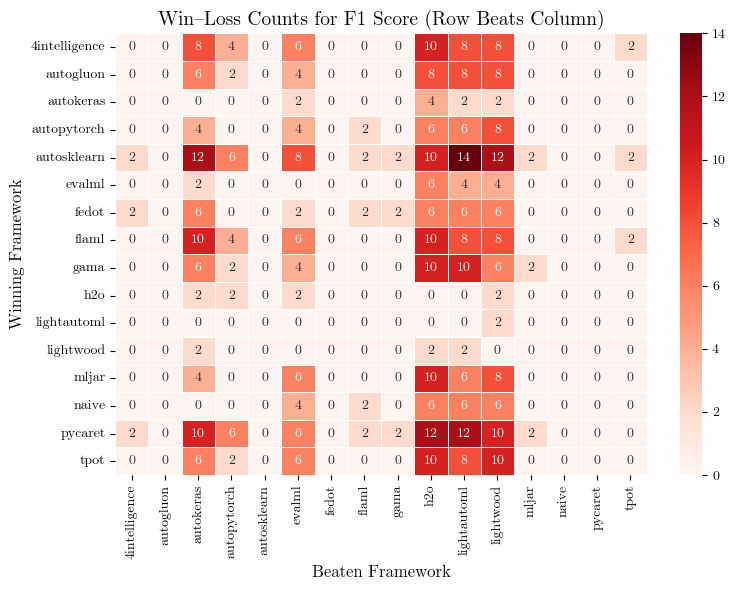

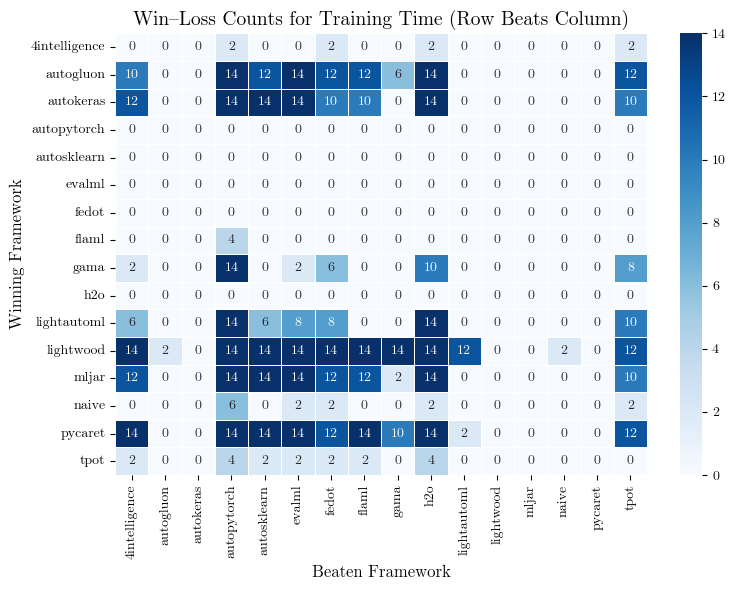

In [21]:
def aggregate_win_loss_matrices(df, posthocs, metric_col):
    """
    Builds a win-loss matrix for a given metric.

    Parameters:
    - df (pd.DataFrame): Original dataset.
    - posthocs (dict): Aggregated post-hoc test results.
    - metric_col (str): The metric to analyze ('f1' or 'training_time').

    Returns:
    - pd.DataFrame: Win-loss matrix for the given metric.
    """
    mean_metric_dict = create_mean_metric_dict(df, dataset_col='dataset', framework_col='framework', metric_col=metric_col)
    return build_win_loss_matrix(posthocs, mean_metric_dict, metric_col=metric_col)

def plot_win_loss_heatmap(df_wins, title, cmap, save_path):
    """
    Plots a heatmap for a given win-loss matrix.

    Parameters:
    - df_wins (pd.DataFrame): Win-loss matrix.
    - title (str): Title of the plot.
    - cmap (str): Color map for the heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        df_wins,
        annot=True,
        cmap=cmap,
        fmt="d",
        linewidths=0.5
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Beaten Framework", fontsize=12)
    plt.ylabel("Winning Framework", fontsize=12)
    plt.tight_layout()

    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the plot
    plt.savefig(save_path, dpi=300)
    plt.show()

# Aggregate post-hoc test results
posthocs = aggregate_posthocs()

# Build win-loss matrices for F1 Score and Training Time
df_wins_f1 = aggregate_win_loss_matrices(df, posthocs, metric_col='f1')
df_wins_time = aggregate_win_loss_matrices(df, posthocs, metric_col='training_time')

# Plot heatmaps for both metrics
plot_win_loss_heatmap(df_wins_f1,
                      title="Win–Loss Counts for F1 Score (Row Beats Column)",
                      cmap="Reds",
                      save_path=f"stats/{scenario}/step_1_per_dataset_win_loss_heatmap_f1.png")

plot_win_loss_heatmap(df_wins_time,
                      title="Win–Loss Counts for Training Time (Row Beats Column)",
                      cmap="Blues",
                      save_path=f"stats/{scenario}/step_1_per_dataset_win_loss_heatmap_time.png")

C:\Users\marce\AppData\Local\Temp\ipykernel_1676\2722647950.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


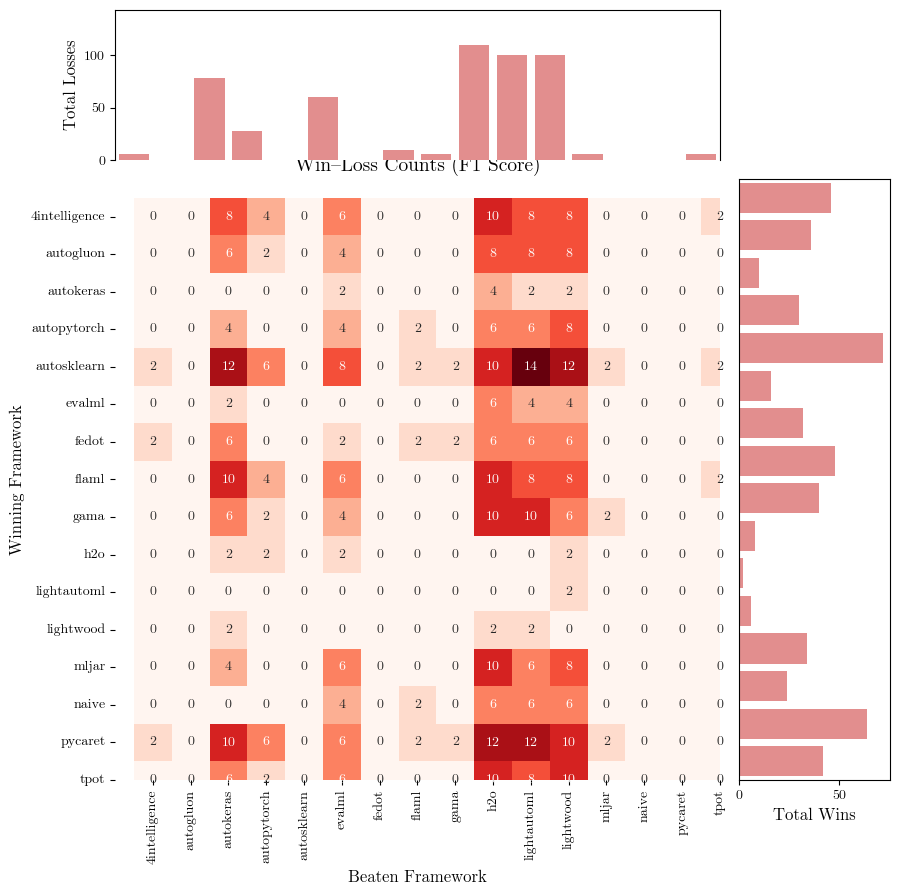

C:\Users\marce\AppData\Local\Temp\ipykernel_1676\2722647950.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


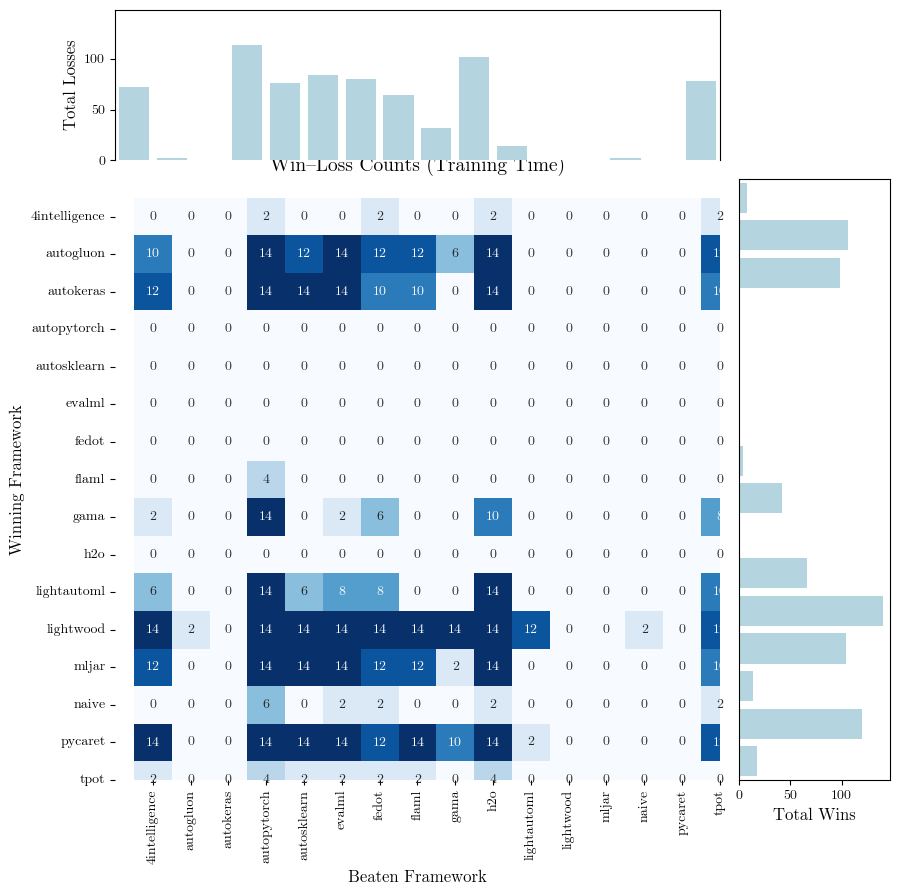

In [22]:
def plot_win_loss_heatmap_with_marginals(df_wins, save_path, title="Win–Loss Counts (Row beats Column)", cmap="Reds"):
    """
    Creates a heatmap of win-loss counts with marginal bar charts for total wins and total losses.

    Parameters:
    - df_wins (pd.DataFrame): F×F DataFrame where:
        - Rows = frameworks (winners)
        - Columns = frameworks (losers)
    - title (str): Title for the heatmap.
    - cmap (str): Color map for the heatmap.
    """
    # Compute total wins (row sums) and total losses (column sums)
    row_sums = df_wins.sum(axis=1)  # Total wins per framework
    col_sums = df_wins.sum(axis=0)  # Total times beaten

    fig = plt.figure(figsize=(10, 10))

    # Create a 2×2 GridSpec layout
    gs = fig.add_gridspec(
        2, 2,
        width_ratios=[4, 1],  # Main heatmap is wider; marginal bar is narrower
        height_ratios=[1, 4],  # Top bar is shorter; main heatmap is taller
        wspace=0.05, 
        hspace=0.05
    )

    # Define subplots
    ax_heatmap = fig.add_subplot(gs[1, 0])  # Main heatmap (bottom-left)
    ax_row_sum = fig.add_subplot(gs[1, 1], sharey=ax_heatmap)  # Row sums (bottom-right)
    ax_col_sum = fig.add_subplot(gs[0, 0], sharex=ax_heatmap)  # Column sums (top-left)

    # -------------------------------
    # 1) Main Heatmap
    # -------------------------------
    sns.heatmap(
        df_wins,
        annot=True,
        cmap=cmap,
        fmt="d",
        ax=ax_heatmap,
        cbar=False  # Hide colorbar to avoid clutter
    )
    ax_heatmap.set_title(title, fontsize=14)
    ax_heatmap.set_xlabel("Beaten Framework", fontsize=12)
    ax_heatmap.set_ylabel("Winning Framework", fontsize=12)

    # -------------------------------
    # 2) Bar chart of total wins (right side)
    # -------------------------------
    sns.barplot(
        x=row_sums.values, 
        y=row_sums.index, 
        orient='h',  # Horizontal bars
        ax=ax_row_sum,
        color='lightcoral' if cmap == "Reds" else 'lightblue'
    )
    ax_row_sum.set_ylabel("")
    ax_row_sum.set_xlabel("Total Wins", fontsize=12)
    ax_row_sum.yaxis.set_visible(False)  # Hide y-axis labels for clarity

    # -------------------------------
    # 3) Bar chart of total losses (top side)
    # -------------------------------
    sns.barplot(
        x=col_sums.index, 
        y=col_sums.values, 
        ax=ax_col_sum,
        color='lightcoral' if cmap == "Reds" else 'lightblue'
    )
    ax_col_sum.set_xlabel("")
    ax_col_sum.set_ylabel("Total Losses", fontsize=12)

    # Rotate x labels for readability
    plt.setp(ax_col_sum.get_xticklabels(), rotation=90)

    # Align top bar with heatmap's x-axis
    ax_col_sum.xaxis.set_visible(False)  # Hide x-axis line
    ax_col_sum.spines["bottom"].set_visible(False)
    ax_col_sum.margins(y=0.3)

    plt.tight_layout()

    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the plot
    plt.savefig(save_path, dpi=300)
    plt.show()

# Call the function for both F1 Score and Training Time
plot_win_loss_heatmap_with_marginals(df_wins_f1,
                                     title="Win–Loss Counts (F1 Score)",
                                     cmap="Reds",
                                     save_path=f"stats/{scenario}/step_1_per_dataset_win_loss_heatmap_with_marginals_f1.png")

plot_win_loss_heatmap_with_marginals(df_wins_time,
                                     title="Win–Loss Counts (Training Time)",
                                     cmap="Blues",
                                     save_path=f"stats/{scenario}/step_1_per_dataset_win_loss_heatmap_with_marginals_time.png")

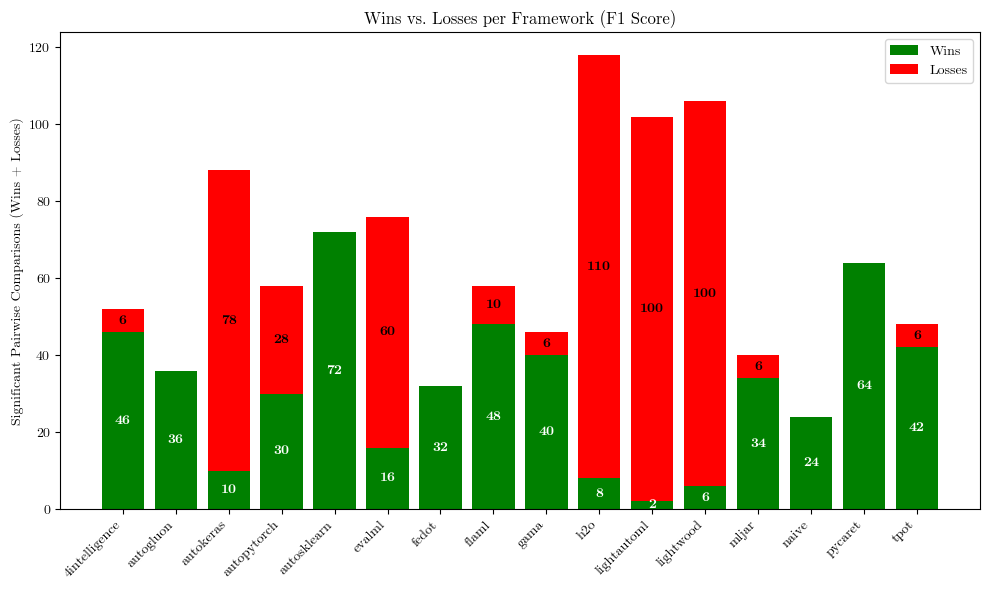

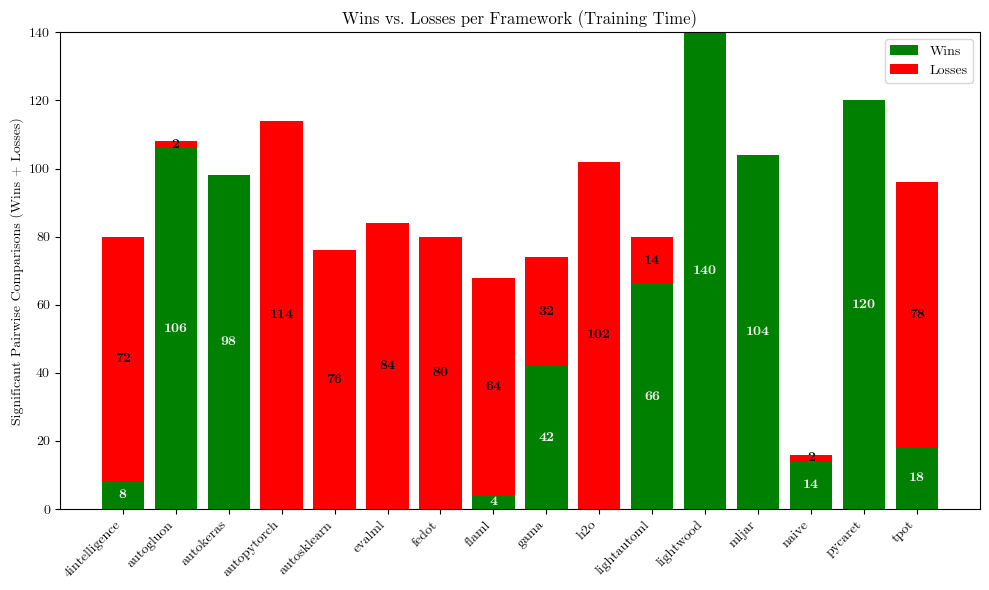

In [23]:
def plot_win_loss_bars(df_wins, save_path, title="Wins vs. Losses per Framework"):
    """
    Creates a stacked bar chart showing wins vs. losses per framework
    based on the significant post-hoc test results.

    Parameters:
    - df_wins (pd.DataFrame): F×F DataFrame where:
        - Rows = frameworks (winner)
        - Columns = frameworks (loser)
        - df_wins.loc[row_fw, col_fw] = # of datasets row_fw beats col_fw
    - title (str): Title for the plot.
    """
    # 1) Compute total wins and losses per framework
    row_sums = df_wins.sum(axis=1)  # Total wins per framework
    col_sums = df_wins.sum(axis=0)  # Total losses per framework

    frameworks = df_wins.index.tolist()
    wins = row_sums.values
    losses = col_sums.values

    # 2) Plot the stacked bars
    x = np.arange(len(frameworks))
    fig, ax = plt.subplots(figsize=(10, 6))

    bars_wins = ax.bar(
        x, wins, label="Wins", color="green"
    )

    bars_losses = ax.bar(
        x, losses, bottom=wins, label="Losses", color="red"
    )

    # 3) Annotate each bar with the corresponding win/loss count
    for i in range(len(frameworks)):
        w, l = wins[i], losses[i]
        
        if w > 0:
            ax.text(x[i], w / 2, str(int(w)), ha="center", va="center", color="white", fontweight="bold")
        
        if l > 0:
            ax.text(x[i], w + (l / 2), str(int(l)), ha="center", va="center", color="black", fontweight="bold")

    # 4) Cosmetic adjustments
    ax.set_xticks(x)
    ax.set_xticklabels(frameworks, rotation=45, ha="right")
    ax.set_ylabel("Significant Pairwise Comparisons (Wins + Losses)")
    ax.set_title(title)
    ax.legend()

    plt.tight_layout()

    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the plot
    plt.savefig(save_path, dpi=300)
    plt.show()

# Call the function for both F1 Score and Training Time
plot_win_loss_bars(df_wins_f1,
                   title="Wins vs. Losses per Framework (F1 Score)",
                   save_path=f"stats/{scenario}/step_1_per_dataset_win_loss_bars_f1.png")

plot_win_loss_bars(df_wins_time,
                   title="Wins vs. Losses per Framework (Training Time)",
                   save_path=f"stats/{scenario}/step_1_per_dataset_win_loss_bars_time.png")

In [24]:
import pandas as pd
import numpy as np

def convert_posthoc_to_long(posthocs):
    """
    Converts post-hoc test results into a long-form DataFrame, ensuring all frameworks appear in both columns.

    Parameters:
    - posthocs (list of dict): List containing post-hoc test results with datasets.

    Returns:
    - pd.DataFrame: Long-form DataFrame with pairwise comparisons.
    """
    posthoc_results_list = []

    # Get full list of all frameworks from all datasets
    all_frameworks = sorted(set(fw for entry in posthocs for fw in entry['posthoc_f1'].index).union(
                             set(fw for entry in posthocs for fw in entry['posthoc_f1'].columns),
                             set(fw for entry in posthocs for fw in entry['posthoc_training_time'].index),
                             set(fw for entry in posthocs for fw in entry['posthoc_training_time'].columns)))

    for entry in posthocs:
        dataset = entry['dataset']
        
        for metric, posthoc_df in [('F1 Score', entry['posthoc_f1']), ('Training Time', entry['posthoc_training_time'])]:
            # Ensure all frameworks are considered, even if missing from posthoc_df
            frameworks = all_frameworks  # Use full list, not just posthoc_df.index

            # Ensure the posthoc DataFrame includes all frameworks
            for fw in frameworks:
                if fw not in posthoc_df.index:
                    posthoc_df.loc[fw] = np.nan  # Add missing row
                if fw not in posthoc_df.columns:
                    posthoc_df[fw] = np.nan  # Add missing column

            for i, fw1 in enumerate(frameworks):
                for j, fw2 in enumerate(frameworks):
                    if i < j:  # Avoid duplicate pairs and diagonal
                        # Retrieve the p-value if it exists, otherwise assign NaN
                        p_value = posthoc_df.loc[fw1, fw2] if fw1 in posthoc_df.index and fw2 in posthoc_df.columns else float("nan")

                        # Randomize assignment to balance framework representation
                        if np.random.rand() > 0.5:  
                            fw1, fw2 = fw2, fw1  # Swap order randomly

                        posthoc_results_list.append({
                            "dataset": dataset,
                            "metric": metric,
                            "Framework A": fw1,
                            "Framework B": fw2,
                            "p-value": p_value
                        })

    return pd.DataFrame(posthoc_results_list)

# Call the function
df_posthoc = convert_posthoc_to_long(posthocs)

In [25]:
def fix_minus_sign(label):
    """Replace Unicode minus sign with a readable fallback."""
    return label.replace("−", r"$\mathdefault{-}$")  # Uses default TeX rendering for minus sign

      dataset    metric Framework A  Framework B       p-value
32         23  F1 Score       fedot       evalml  1.000000e+00
33         23  F1 Score       fedot        flaml  1.000000e+00
34         23  F1 Score       fedot         gama  1.000000e+00
35         23  F1 Score       fedot          h2o  1.000425e-07
44         23  F1 Score       fedot       evalml  1.000000e+00
55         23  F1 Score       fedot       evalml  1.000000e+00
65         23  F1 Score       fedot       evalml  1.000000e+00
66         23  F1 Score       fedot        flaml  1.000000e+00
245        36  F1 Score       fedot       evalml  1.000000e+00
246        36  F1 Score       fedot        flaml  1.000000e+00
247        36  F1 Score       fedot         gama  1.000000e+00
259        36  F1 Score       fedot  autosklearn  1.000000e+00
260        36  F1 Score       fedot        flaml  1.000000e+00
272        36  F1 Score       fedot       evalml  1.000000e+00
273        36  F1 Score       fedot        flaml  1.000

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


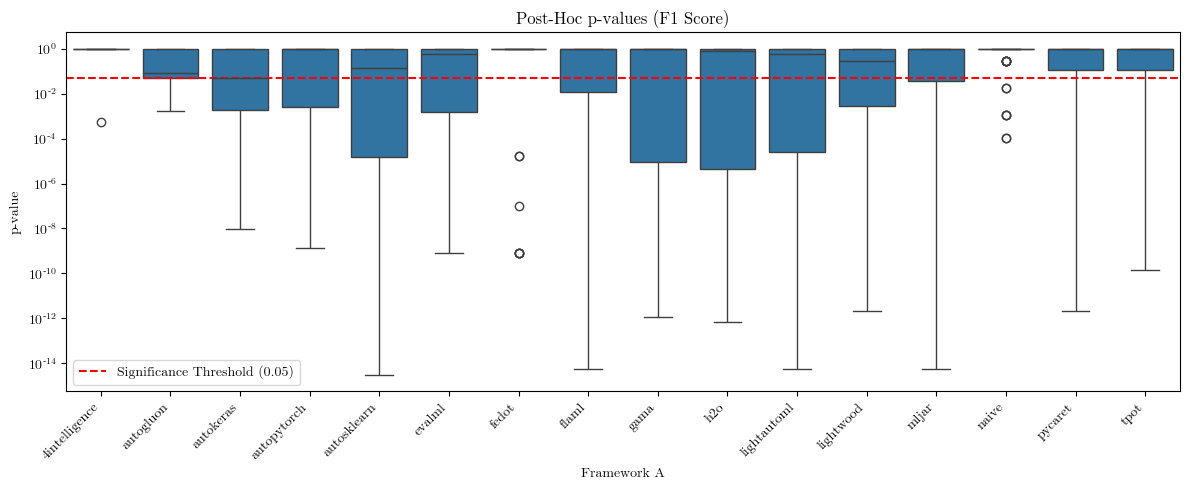

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


      dataset         metric Framework A  Framework B   p-value
125        23  Training Time       fedot       evalml  1.000000
126        23  Training Time       fedot        flaml  1.000000
127        23  Training Time       fedot         gama  0.039763
128        23  Training Time       fedot          h2o  1.000000
139        23  Training Time       fedot  autopytorch  1.000000
140        23  Training Time       fedot        flaml  1.000000
141        23  Training Time       fedot         gama  0.039763
152        23  Training Time       fedot  autopytorch  1.000000
153        23  Training Time       fedot        flaml  1.000000
404        36  Training Time       fedot       evalml  1.000000
425        36  Training Time       fedot       evalml  1.000000
435        36  Training Time       fedot        flaml  1.000000
436        36  Training Time       fedot         gama  0.401824
644        54  Training Time       fedot  autosklearn  1.000000
645        54  Training Time       fedot

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


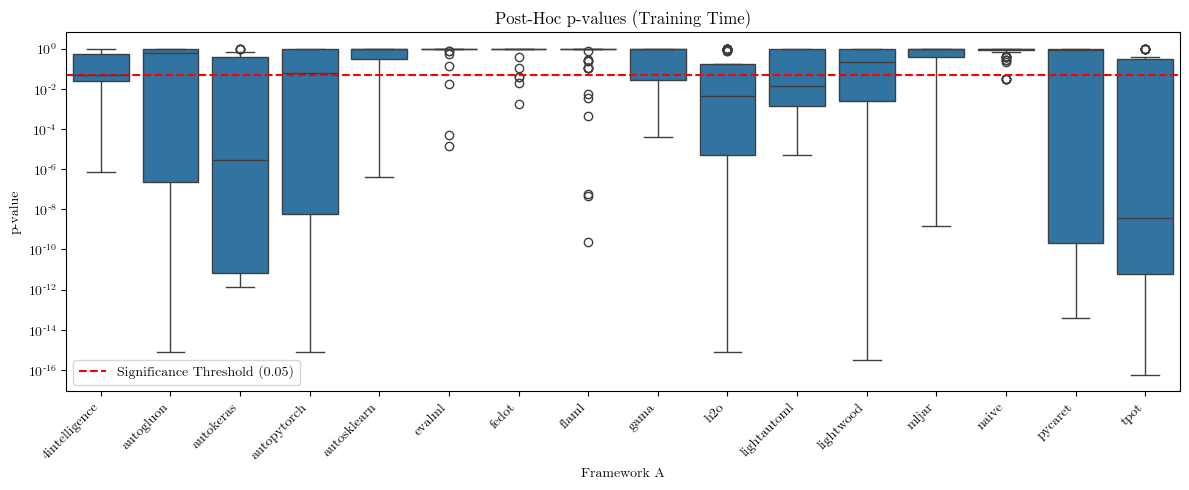

In [26]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_posthoc_pvalues(df_posthoc, metric, title, save_path):
    """
    Creates a boxplot for post-hoc p-values of a given metric, ensuring all frameworks appear.

    Parameters:
    - df_posthoc (pd.DataFrame): DataFrame containing post-hoc test results.
    - metric (str): The metric to analyze ('F1 Score' or 'Training Time').
    - title (str): Title for the plot.
    - save_path (str): Path to save the generated plot.
    """
    plt.figure(figsize=(12, 5))

    # Compute all frameworks from 'Framework A' and 'Framework B'
    all_frameworks = sorted(set(df_posthoc["Framework A"]).union(set(df_posthoc["Framework B"])))

    # Filter for the metric of interest
    df_filtered = df_posthoc[df_posthoc["metric"] == metric].copy()

    if df_filtered.empty:
        print(f"⚠️ No post-hoc results for {metric}. Skipping plot.")
        return

    # Ensure missing frameworks in 'Framework A' appear with NaN
    existing_frameworks_A = set(df_filtered["Framework A"])
    existing_frameworks_B = set(df_filtered["Framework B"])

    missing_frameworks_A = existing_frameworks_B - existing_frameworks_A  # Frameworks only in 'B'

    if missing_frameworks_A:
        print(f"⚠️ Fixing missing frameworks in 'Framework A': {missing_frameworks_A}")

        missing_rows = pd.DataFrame({
            "Framework A": list(missing_frameworks_A),
            "p-value": np.nan,
            "metric": metric
        })
        df_filtered = pd.concat([df_filtered, missing_rows], ignore_index=True)

    # Ensure `Framework A` includes frameworks that appear in `Framework B`
    frameworks_in_A = set(df_filtered["Framework A"])
    frameworks_in_B = set(df_filtered["Framework B"])

    missing_from_A = frameworks_in_B - frameworks_in_A  # Any framework that is only in "Framework B"
    if missing_from_A:
        print(f"⚠️ Fixing missing frameworks from 'Framework B' into 'Framework A': {missing_from_A}")
        for fw in missing_from_A:
            df_filtered = pd.concat([df_filtered, pd.DataFrame({
                "Framework A": [fw],
                "p-value": np.nan,
                "metric": metric
            })], ignore_index=True)

    # Check if `fedot` has valid p-values
    print(df_filtered[df_filtered["Framework A"] == "fedot"])

    # # Replace NaN p-values with 1.0 to make them visible but non-significant
    # df_filtered["p-value"].fillna(1.0, inplace=True)

    # Plot the p-values
    sns.boxplot(x="Framework A", y="p-value", data=df_filtered, order=all_frameworks)

    plt.axhline(y=alpha, color='r', linestyle='--', label=f'Significance Threshold ({alpha})')
    plt.title(title)
    plt.legend()

    # Improve x/y axis readability
    plt.yscale('log')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Save the plot
    plt.savefig(save_path, dpi=300)
    plt.show()

# Call the function for both F1 Score and Training Time
plot_posthoc_pvalues(df_posthoc, metric="F1 Score", 
                     title="Post-Hoc p-values (F1 Score)", 
                     save_path=f"stats/{scenario}/step_1_per_dataset_post_hoc_box_f1.png")

plot_posthoc_pvalues(df_posthoc, metric="Training Time", 
                     title="Post-Hoc p-values (Training Time)", 
                     save_path=f"stats/{scenario}/step_1_per_dataset_post_hoc_box_time.png")

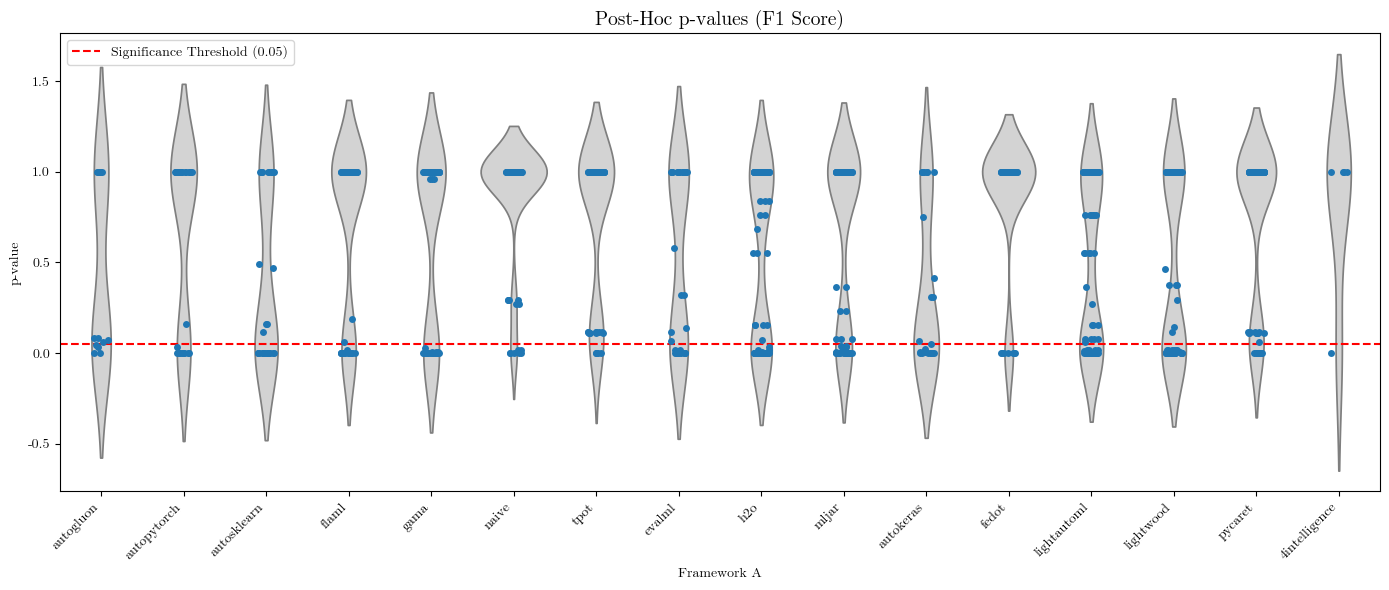

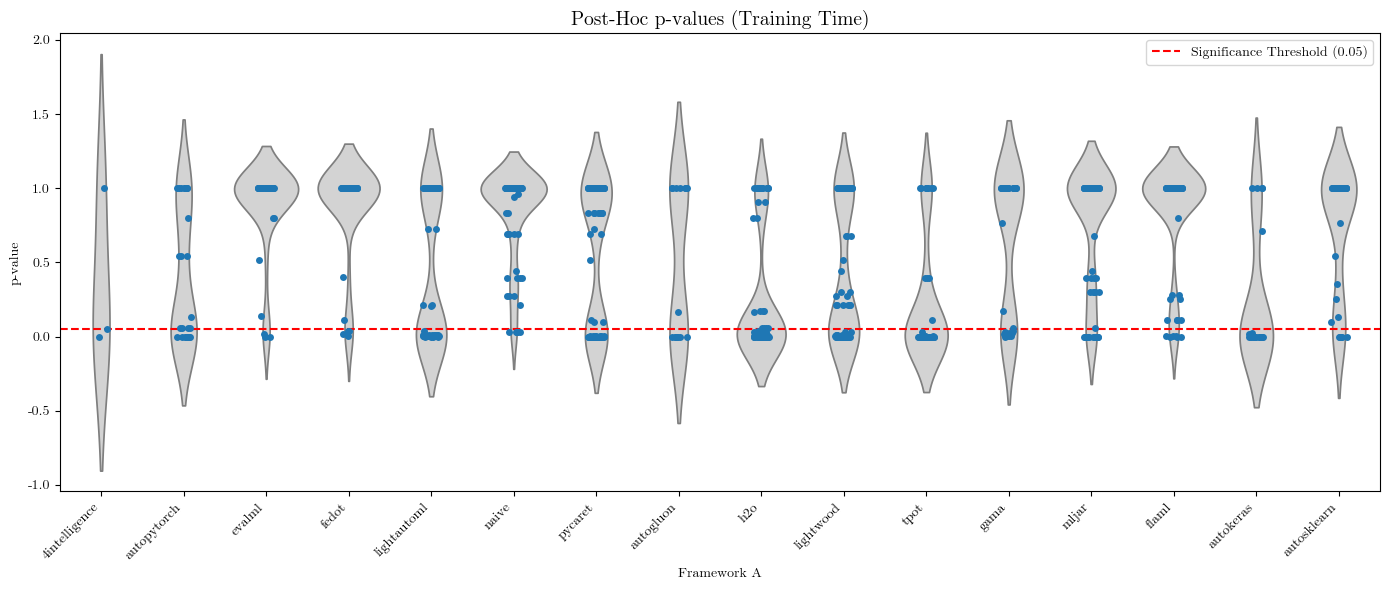

In [27]:
def plot_violin_strip_pvalues(df_posthoc, metric, title, save_path):
    """
    Creates a violin + strip plot for post-hoc p-values of a given metric.

    Parameters:
    - df_posthoc (pd.DataFrame): DataFrame containing post-hoc test results.
    - metric (str): The metric to analyze ('F1 Score' or 'Training Time').
    - title (str): Title for the plot.
    - save_path (str): Path to save the generated plot.
    """
    plt.figure(figsize=(14, 6))
    
    df_filtered = df_posthoc[df_posthoc["metric"] == metric]

    # Violin plot (distribution)
    sns.violinplot(x="Framework A", y="p-value", data=df_filtered, inner=None, color="lightgray")
    
    # Strip plot (individual data points)
    sns.stripplot(x="Framework A", y="p-value", data=df_filtered, jitter=True, dodge=True)
    
    # Significance threshold
    plt.axhline(y=alpha, color='r', linestyle='--', label=f'Significance Threshold ({alpha})')
    plt.title(title, fontsize=14)
    plt.ylabel("p-value")
    plt.legend()

    # Improve x-axis readability
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Ensure the save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the plot
    plt.savefig(save_path, dpi=300)
    plt.show()

# Call the function for both F1 Score and Training Time
plot_violin_strip_pvalues(df_posthoc, metric="F1 Score", 
                          title="Post-Hoc p-values (F1 Score)", 
                          save_path=f"stats/{scenario}/step_1_per_dataset_post_hoc_violin_f1.png")

plot_violin_strip_pvalues(df_posthoc, metric="Training Time", 
                          title="Post-Hoc p-values (Training Time)", 
                          save_path=f"stats/{scenario}/step_1_per_dataset_post_hoc_violin_time.png")

## Extra

In [28]:
def extract_significant_comparisons(df_posthoc):
    """
    Extracts significant post-hoc comparisons for F1 Score and Training Time.

    Parameters:
    - df_posthoc (pd.DataFrame): Long-form DataFrame containing post-hoc test results.

    Returns:
    - pd.DataFrame: Summary of significant pairwise comparisons.
    """
    # Identify significant comparisons
    significant_f1 = df_posthoc[(df_posthoc["metric"] == "F1 Score") & (df_posthoc["p-value"] < alpha)]
    significant_time = df_posthoc[(df_posthoc["metric"] == "Training Time") & (df_posthoc["p-value"] < alpha)]

    # Rename dataset column for consistency
    significant_f1 = significant_f1.rename(columns={"dataset": "Dataset"})
    significant_time = significant_time.rename(columns={"dataset": "Dataset"})

    # Create a summary table for significant differences in F1 Score
    significance_summary = pd.DataFrame({
        "Dataset": significant_f1["Dataset"],
        "Framework A": significant_f1["Framework A"],
        "Framework B": significant_f1["Framework B"],
        "p-value (F1 Score)": significant_f1["p-value"]
    })

    # Merge with significant training time comparisons
    significant_time = significant_time.rename(columns={"p-value": "p-value (Training Time)"})
    significance_summary = significance_summary.merge(
        significant_time[["Dataset", "Framework A", "Framework B", "p-value (Training Time)"]],
        on=["Dataset", "Framework A", "Framework B"],
        how="left"
    )

    return significance_summary.dropna()  # Remove rows with no significant training time comparisons

# Call the function
significant_results = extract_significant_comparisons(df_posthoc)
significant_results

,Dataset,Framework A,Framework B,p-value (F1 Score),p-value (Training Time)
5,23,h2o,lightwood,1.186450e-05,8.628752e-15
10,23,lightautoml,fedot,3.290787e-07,9.281849e-03
11,23,lightwood,lightautoml,3.268878e-05,6.797425e-04
14,23,lightwood,lightautoml,3.268878e-05,6.797425e-04
17,23,h2o,gama,2.259529e-09,3.504586e-02
...,...,...,...,...,...
219,40691,h2o,gama,1.535332e-10,4.208907e-03
229,40691,gama,h2o,1.535332e-10,4.208907e-03
230,40691,gama,h2o,1.535332e-10,4.208907e-03
234,40691,mljar,h2o,3.593405e-02,3.327887e-09


In [29]:
def summarize_posthoc(df):
    summary = ""

    for dataset in df['dataset'].unique():
        dataset_results = df[df['dataset'] == dataset]
        
        summary += f"### Dataset {dataset} Analysis\n"
        
        for metric in dataset_results['metric'].unique():
            metric_results = dataset_results[dataset_results['metric'] == metric]
            significant_pairs = metric_results[metric_results['p-value'] < alpha]
            
            if significant_pairs.empty:
                summary += f"- No significant differences found for {metric}.\n"
            else:
                summary += f"- Significant differences for {metric}:\n"
                for _, row in significant_pairs.iterrows():
                    summary += f"  - {row['Framework A']} vs {row['Framework B']}: p = {row['p-value']:.3f}\n"
        
        summary += "\n"
    
    return summary

# Generate summary
posthoc_summary = summarize_posthoc(df_posthoc)
print(posthoc_summary)

### Dataset 23 Analysis
- Significant differences for F1 Score:
  - autogluon vs autokeras: p = 0.002
  - gama vs h2o: p = 0.000
  - gama vs lightautoml: p = 0.000
  - autogluon vs autokeras: p = 0.002
  - h2o vs flaml: p = 0.000
  - h2o vs lightwood: p = 0.000
  - mljar vs h2o: p = 0.000
  - autokeras vs autosklearn: p = 0.000
  - evalml vs autokeras: p = 0.000
  - fedot vs h2o: p = 0.000
  - lightautoml vs fedot: p = 0.000
  - lightwood vs lightautoml: p = 0.000
  - gama vs h2o: p = 0.000
  - lightautoml vs gama: p = 0.000
  - lightwood vs lightautoml: p = 0.000
  - gama vs h2o: p = 0.000
  - gama vs lightautoml: p = 0.000
  - h2o vs gama: p = 0.000
  - lightautoml vs lightwood: p = 0.000
  - lightautoml vs mljar: p = 0.000
  - lightautoml vs naive: p = 0.016
  - lightautoml vs pycaret: p = 0.000
  - tpot vs lightautoml: p = 0.000
  - h2o vs gama: p = 0.000
  - lightwood vs h2o: p = 0.000
  - gama vs h2o: p = 0.000
  - lightautoml vs gama: p = 0.000
  - lightwood vs lightautoml: p = 